### Clustering of words based on UMAP and sbert
[sbert](https://www.sbert.net/)
[UMAP](https://umap-learn.readthedocs.io/en/latest/index.html)

In [209]:
import json
# Used to import data from S3.
import pandas as pd

# Used to create the dense document vectors.
import torch
from sentence_transformers import SentenceTransformer

# Used to create and store the Faiss index.
import faiss
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Used to do vector searches and display the results.
#from vector_engine.utils import vector_search, id2details

### Import
Import the file exported from the excel file

In [234]:
defFile1 = "primitiveDef.json"
defFile2 = "skillDef.json"
defFile3 = "taskDef.json"

with open('D:/1. Papers/4. MyPapers/6_(20210609) Skill taxonomy/skill-taxonomy-extraction/data/in/' + str(defFile1)) as json_file:
    defWord1 = json.load(json_file)

with open('D:/1. Papers/4. MyPapers/6_(20210609) Skill taxonomy/skill-taxonomy-extraction/data/in/' + str(defFile2)) as json_file:
    defWord2 = json.load(json_file)

with open('D:/1. Papers/4. MyPapers/6_(20210609) Skill taxonomy/skill-taxonomy-extraction/data/in/' + str(defFile3)) as json_file:
    defWord3 = json.load(json_file)


defWord = defWord3

print(len(defWord))

55


### Preprocessing
Follow guide from: https://www.pinecone.io/learn/faiss-tutorial/

In [235]:
import random
# remove duplicates
defSing = [word for word in list(set(defWord)) if type(word) is str]

print(len(defSing))
random.shuffle(defSing)

40


In [236]:
from sentence_transformers import SentenceTransformer

# initialize sentence transformer model
#model = SentenceTransformer('bert-base-nli-mean-tokens') #this is outdated: https://huggingface.co/sentence-transformers/bert-base-nli-mean-tokens
# info: https://www.sbert.net/docs/pretrained_models.html
model = SentenceTransformer('all-mpnet-base-v2') # SentenceTransformer('all-mpnet-base-v2')
sentence_embeddings = model.encode(defSing)
print(sentence_embeddings.shape)

(40, 768)


### Clustering

In [237]:
n_neighbors = 10
n_components = 2

import umap
umap_embeddings = umap.UMAP(n_neighbors=n_neighbors, 
                            n_components=n_components, 
                            metric='cosine').fit_transform(sentence_embeddings)

In [250]:
from sklearn.cluster import KMeans

cluster = KMeans(n_clusters=6, n_init=200, random_state=0).fit(umap_embeddings)

5


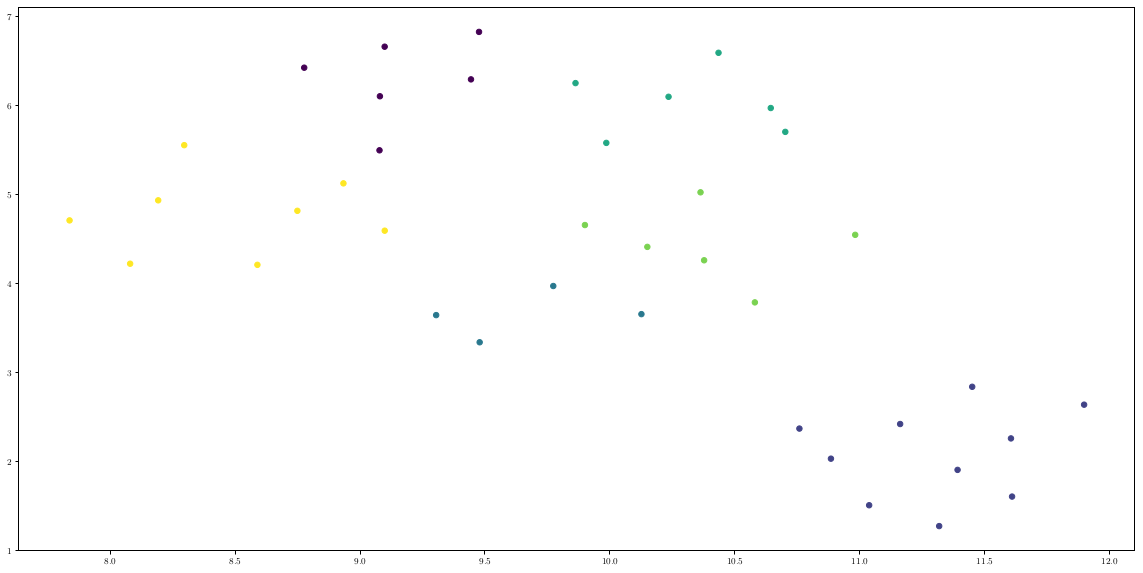

In [251]:
import matplotlib.pyplot as plt

# Prepare data
result = pd.DataFrame(umap_embeddings, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
clustered = result.loc[result.labels != -1, :]
print(max(result.labels))
plt.scatter(clustered.x, clustered.y, c=cluster.labels_, s=30, cmap='viridis')

In [252]:
d = {'primitive': defSing, 'cluster':result['labels'], 'x': result['x'], 'y': result['y']}

clusterDF = pd.DataFrame(d)
clusterDF['Doc_ID'] = range(0,len(clusterDF))

primitivesPerTopic = clusterDF.groupby(['cluster'], as_index = False).agg({'primitive': ' '.join})

#print(primitivesPerTopic)

As suggested by this [guide](https://towardsdatascience.com/keyword-extraction-with-bert-724efca412ea) we get the most recurring keywords for each cluster

In [253]:
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance
from nltk.corpus import wordnet as wn

# group by "X" column
groups = clusterDF.groupby(['cluster'])
  
labels = []

# extract keys from groups
keys = groups.groups.keys()

for i in keys:

    g = groups.get_group(i)
    n_gram_range = (1, 1)
    stop_words = "english"

    words = g['primitive'].to_list()

    count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit(words)
    candidates = count.get_feature_names()

    model = SentenceTransformer('all-mpnet-base-v2') # msmarco-distilbert-base-tas-b
    doc_embedding = model.encode(words)
    candidate_embeddings = model.encode(candidates)

    top_n = 2
    distances = cosine_similarity(doc_embedding, candidate_embeddings)
    keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]

    # #print(words)
    # syns = words[0]
    # lch = syns[0]
    # for word in words[1:]:
    #     print(word)
    #     wordHyper = wn.synsets(word)
    #     print(wordHyper)
    #     #lch = word.lowest_common_hypernyms(lch)

    print("GROUP: " + str(i))
    
    print(keywords)

    matchedKeywords = str(keywords[0] + "-" + keywords[1])
    # print(matchedKeywords)
    
    labels.append(matchedKeywords)

GROUP: 0
['fix', 'support']
GROUP: 1
['place', 'pick']
GROUP: 2
['hole', 'peg']
GROUP: 3
['sew', 'weld']
GROUP: 4
['hole', 'peg']
GROUP: 5
['manipulation', 'complex']


In [254]:
# By knowing the names extracted from the clusters we can then assign them to the clusterDF which can plot the scatter plot
clusterDF["keyword"] = ""


for idx, row in clusterDF.iterrows(): 
    for i in range(0,len(labels)): # clusters statr from 0
        if clusterDF.iloc[idx]["cluster"] == (i):  
            clusterDF.at[idx, "keyword"] = labels[i]

#print(clusterDF.groupby('cluster').get_group(0))
# print(max(clusterDF["cluster"]))
# print(min(clusterDF["x"]))
# print(max(clusterDF["x"]))
# print(min(clusterDF["y"]))
# print(max(clusterDF["y"]))

C:\Users\z0040kve\AppData\Local\Temp/ipykernel_21604/1572877211.py:68: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


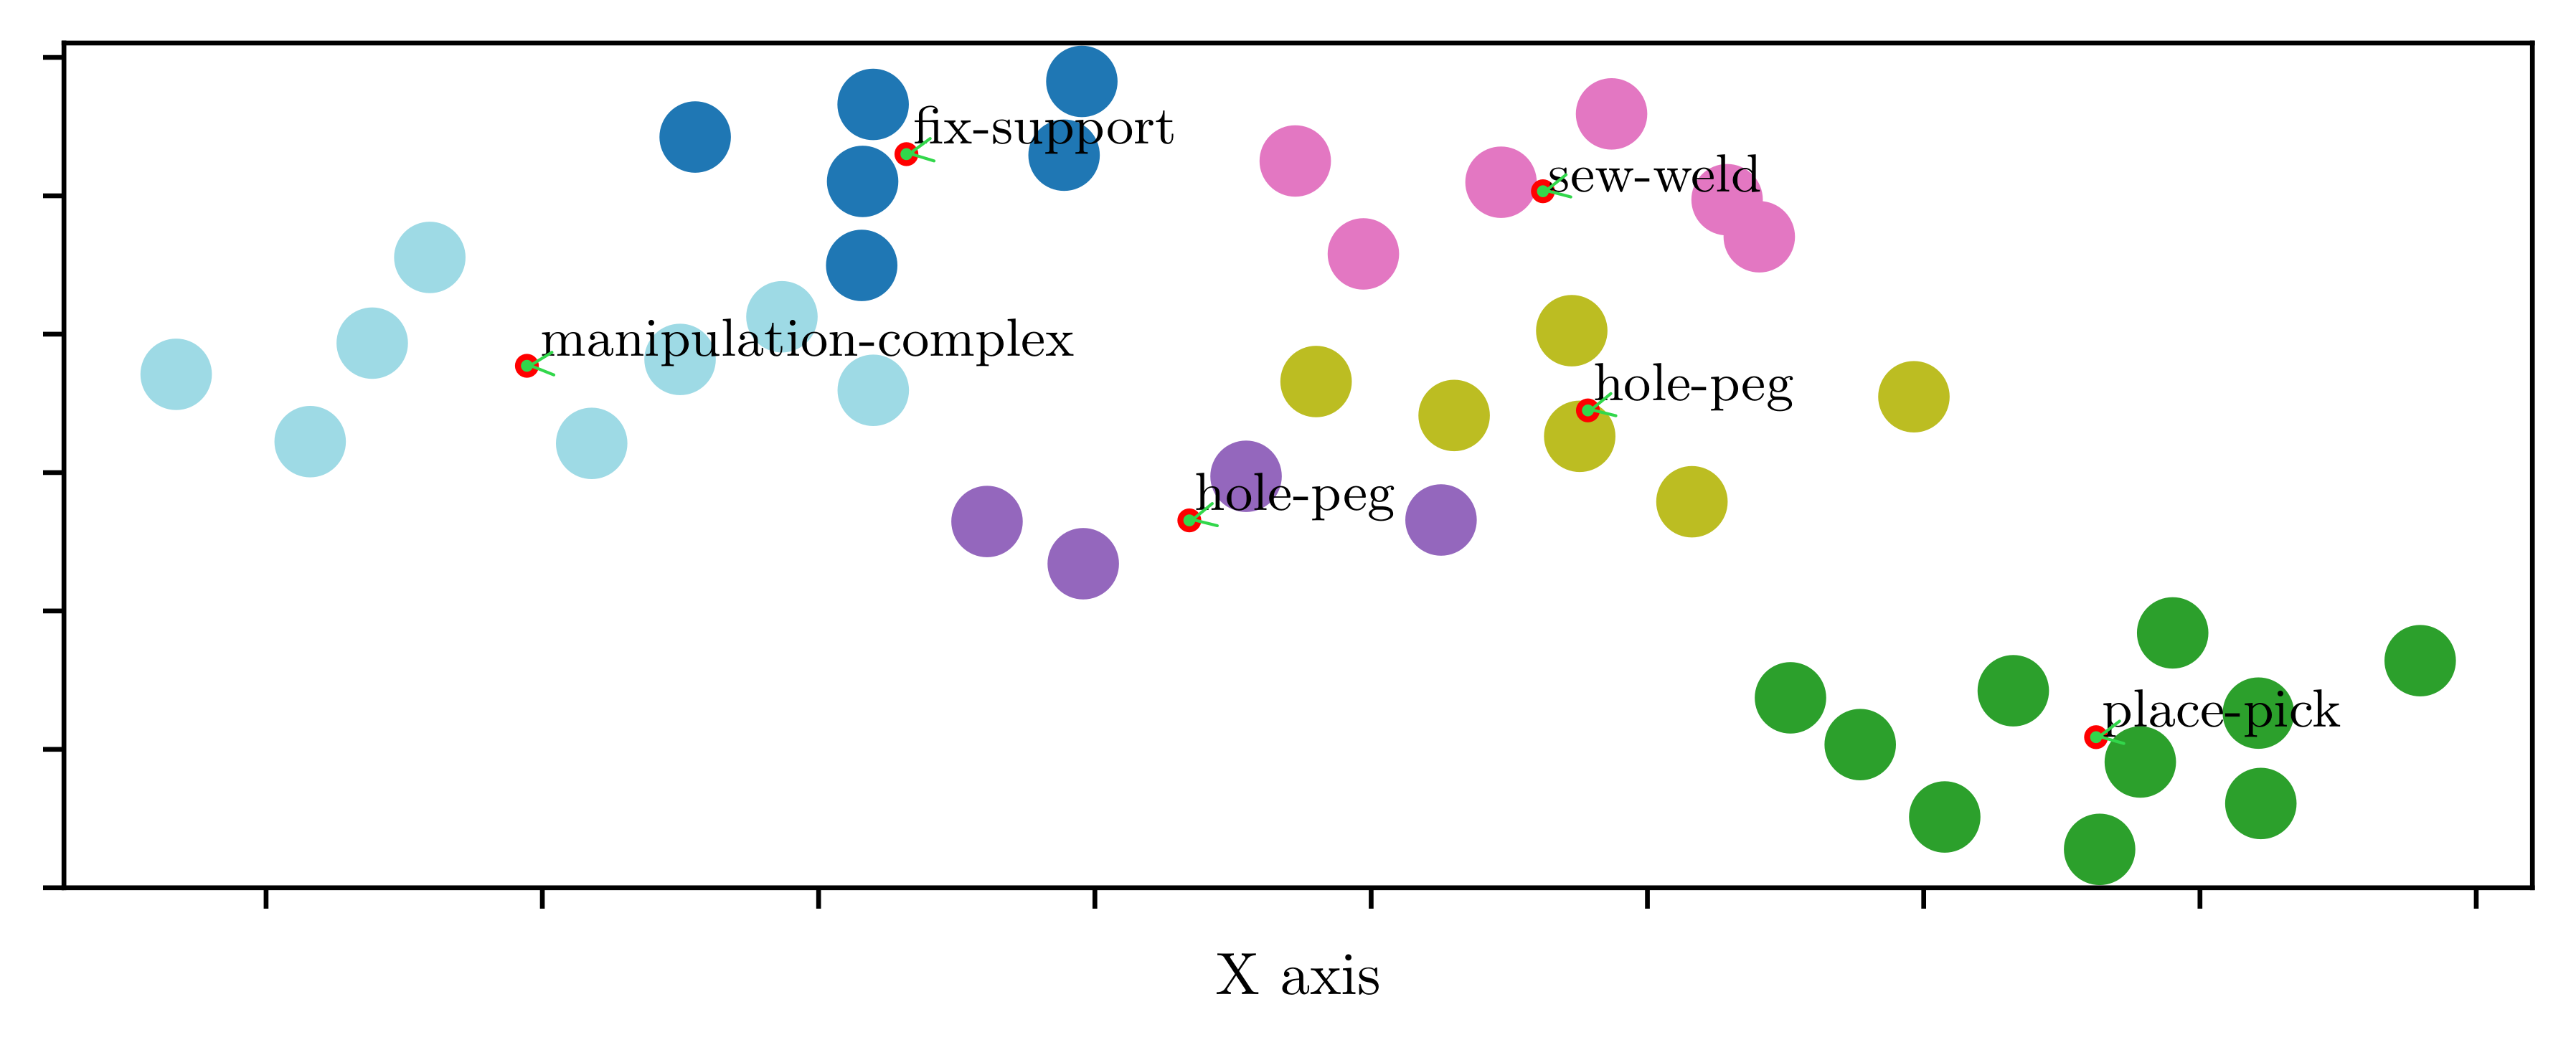

In [255]:
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
from adjustText import adjust_text # to avoid overlapping text

# Latex export
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

# Visualize clusters with most appearing keywords
# (20,10)
fig, ax = plt.subplots(figsize=(7.4, 2.6), dpi=600)
outliers = clusterDF.loc[clusterDF.cluster == -1, :]
clustered = clusterDF.loc[clusterDF.cluster != -1, :]
plt.rcParams.update({'font.size': 9.5})
#pri

#plt.figure(figsize=(3240/600, 1280/600), dpi=600)

#plt.scatter(outliers.x, outliers.y, color='#F2F2F2', s=30)
plt.scatter(clustered.x, clustered.y, c=clustered.cluster, s=120, cmap='tab20')
#plt.colorbar()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

#loop through labels and plot each cluster

# group by "X" column
groups = clustered.groupby('cluster')
  
# extract keys from groups
keys = groups.groups.keys()
texts = []

for i in keys:

    x = groups.get_group(i)['x'].mean()
    y = groups.get_group(i)['y'].mean()

    plt.plot(x, y, marker="o", markersize=3, markeredgecolor="red", markerfacecolor="#32d74b")
    #plt.annotate(groups.get_group(i).iloc[0]["keyword"], xy = (x,y))
    texts.append(plt.text(x, y, groups.get_group(i).iloc[0]["keyword"]))

#plt.xticks(color='w')
#plt.yticks(color='w')

plt.xlabel("X axis", fontsize=10)

#visualiplt.ylabel("Dimension 2", fontsize=10)

# import tikzplotlib

# tikzplotlib.save("D:/1. Papers/4. MyPapers/6_(20210609) Skill taxonomy/figures/knnClusteringWords.tex")
#plt.plot([6.5, 6.5], [8, 14], color='#32d74b', linestyle='--', linewidth=0.6)
#plt.plot([2, 9], [11, 11], color='#32d74b', linestyle='--', linewidth=0.6)
# adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
adjust_text(texts, only_move={'points':'x','texts':'y','objects':'x'}, arrowprops=dict(arrowstyle="->", color='#32d74b', lw=0.5))
#plt.plot([3, 11], [10.5, 10.5], color='#8A8AFF', linestyle='--', linewidth=1)

plt.savefig('D:/1. Papers/4. MyPapers/6_(20210609) Skill taxonomy/figures/knnClusteringWords6_tsk.png', dpi=600, bbox_inches = 'tight')
plt.savefig('D:/1. Papers/4. MyPapers/6_(20210609) Skill taxonomy/figures/knnClusteringWords6_tsk.pgf', dpi=600, bbox_inches = 'tight')
plt.show()